In [4]:
# 📦 Importação de bibliotecas
import numpy as np
import matplotlib.pyplot as plt

# 🎨 Configuração para gráficos maiores
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
# 🔁 Funções utilitárias

def sigmoid(x):
    """Função de ativação sigmoid"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip para evitar overflow

def sigmoid_derivative(x):
    """Derivada da função sigmoid"""
    s = sigmoid(x)
    return s * (1 - s)

def mse(y_true, y_pred):
    """Calcula o erro médio quadrático entre dois arrays"""
    return np.mean(np.square(y_true - y_pred))

def vc_rc(t, r=5, c=0.1, vin=1):
    """
    Calcula a tensão de um capacitor em um circuito RC série
    """
    tau = -t / (r * c)
    vc = vin * (1 - np.exp(tau))
    return vc


In [6]:
# 🧠 Classe Rede Neural MLP

class RedeNeuralMLP:
    def __init__(self, x, y, n_hidden=15, taxa_aprendizado=0.1):
        self.entrada = x
        self.y = y
        self.taxa_aprendizado = taxa_aprendizado
        
        self.pesos_0 = np.random.rand(self.entrada.shape[1], n_hidden)
        self.pesos_1 = np.random.rand(n_hidden, 1)
        
        self.saida = np.zeros(y.shape)
        self.historico_erro = []
    
    def feedforward(self):
        self.pot_ativ_0 = np.dot(self.entrada, self.pesos_0)
        self.camada_0 = sigmoid(self.pot_ativ_0)
        
        self.pot_ativ_1 = np.dot(self.camada_0, self.pesos_1)
        self.camada_1 = sigmoid(self.pot_ativ_1)
        
        return self.camada_1

    def backpropagation(self):
        erro_saida = self.y - self.saida
        delta_saida = erro_saida * sigmoid_derivative(self.pot_ativ_1)
        gradiente_pesos_1 = np.dot(self.camada_0.T, delta_saida)
        
        erro_oculta = np.dot(delta_saida, self.pesos_1.T)
        delta_oculta = erro_oculta * sigmoid_derivative(self.pot_ativ_0)
        gradiente_pesos_0 = np.dot(self.entrada.T, delta_oculta)
        
        self.pesos_1 += self.taxa_aprendizado * gradiente_pesos_1
        self.pesos_0 += self.taxa_aprendizado * gradiente_pesos_0

    def treinar_uma_epoca(self):
        self.saida = self.feedforward()
        self.backpropagation()
        erro_atual = mse(self.y, self.saida)
        self.historico_erro.append(erro_atual)
        return erro_atual

    def treinar(self, epocas=1000, verbose=True):
        print(f"Iniciando treinamento por {epocas} épocas...")
        for epoca in range(epocas):
            erro = self.treinar_uma_epoca()
            if verbose and (epoca + 1) % 100 == 0:
                print(f"Época {epoca + 1}/{epocas} - Erro: {erro:.6f}")
        print(f"Treinamento concluído! Erro final: {self.historico_erro[-1]:.6f}")

    def prever(self, x):
        entrada_original = self.entrada
        self.entrada = x
        saida = self.feedforward()
        self.entrada = entrada_original
        return saida

    def plotar_erro(self):
        plt.figure()
        plt.plot(self.historico_erro, 'r-', linewidth=2)
        plt.xlabel('Época')
        plt.ylabel('Erro Médio Quadrático (MSE)')
        plt.title('Convergência da Rede Neural')
        plt.grid(True, alpha=0.3)
        plt.show()

    def plotar_pesos(self, titulo="Distribuição dos Pesos"):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(self.pesos_0.flatten(), bins=20, alpha=0.7, color='blue')
        plt.title('Pesos da Camada Oculta (W0)')
        plt.xlabel('Valor do Peso')
        plt.ylabel('Frequência')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.hist(self.pesos_1.flatten(), bins=20, alpha=0.7, color='red')
        plt.title('Pesos da Camada de Saída (W1)')
        plt.xlabel('Valor do Peso')
        plt.ylabel('Frequência')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


In [7]:
# 🔬 Demonstração completa com os dados do capacitor RC

def demonstracao_completa():
    print("=== DEMONSTRAÇÃO DA REDE NEURAL MLP ===\n")
    
    print("1. Gerando dados do circuito RC...")
    t = np.arange(0, 3, 0.1)
    vc = vc_rc(t)
    t_norm = t / np.amax(t)
    
    print("2. Dividindo dados em treino (60%) e teste (40%)...")
    tam_treino = int(len(vc) * 0.6)
    x_train = t_norm[:tam_treino].reshape(-1, 1)
    y_train = vc[:tam_treino].reshape(-1, 1)
    x_test = t_norm[tam_treino:].reshape(-1, 1)
    y_test = vc[tam_treino:]
    
    print("3. Visualizando dados de treino e teste...")
    plt.figure()
    plt.plot(x_train.flatten(), y_train.flatten(), 'b-', label='Treino')
    plt.plot(x_test.flatten(), y_test, 'r-', label='Teste')
    plt.xlabel('Tempo (normalizado)')
    plt.ylabel('Tensão (V)')
    plt.title('Divisão dos Dados')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\n4. Criando e treinando a rede neural...")
    rede = RedeNeuralMLP(x_train, y_train, n_hidden=15, taxa_aprendizado=0.1)
    print("Visualizando pesos antes do treinamento...")
    rede.plotar_pesos("Pesos Antes do Treinamento")
    rede.treinar(epocas=500, verbose=True)
    print("Visualizando pesos após o treinamento...")
    rede.plotar_pesos("Pesos Após o Treinamento")
    
    print("\n5. Visualizando convergência...")
    rede.plotar_erro()
    
    print("\n6. Testando a rede...")
    predicoes = rede.prever(x_test)
    erro_teste = mse(y_test.reshape(-1, 1), predicoes)
    print(f"Erro de teste (MSE): {erro_teste:.6f}")
    
    print("\n7. Visualização final...")
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(x_test.flatten(), y_test, 'b-', label='Reais')
    plt.plot(x_test.flatten(), predicoes.flatten(), 'r--', label='Predições')
    plt.title('Teste - Real vs Predito')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(x_train.flatten(), y_train.flatten(), 'g-', label='Treino')
    plt.plot(x_test.flatten(), y_test, 'b-', label='Reais Teste')
    plt.plot(x_test.flatten(), predicoes.flatten(), 'r--', label='Predito')
    plt.title('Geral - Treino + Teste')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n8. Resumo:")
    print(f"- Erro final de treinamento: {rede.historico_erro[-1]:.6f}")
    print(f"- Erro de teste: {erro_teste:.6f}")
    print(f"- Parâmetros: {rede.pesos_0.size + rede.pesos_1.size}")
    print(f"- Arquitetura: {x_train.shape[1]} -> {rede.pesos_0.shape[1]} -> {rede.pesos_1.shape[1]}")
    
    print("\n=== FIM DA DEMONSTRAÇÃO ===")
    return rede


=== DEMONSTRAÇÃO DA REDE NEURAL MLP ===

1. Gerando dados do circuito RC...
2. Dividindo dados em treino (60%) e teste (40%)...
3. Visualizando dados de treino e teste...


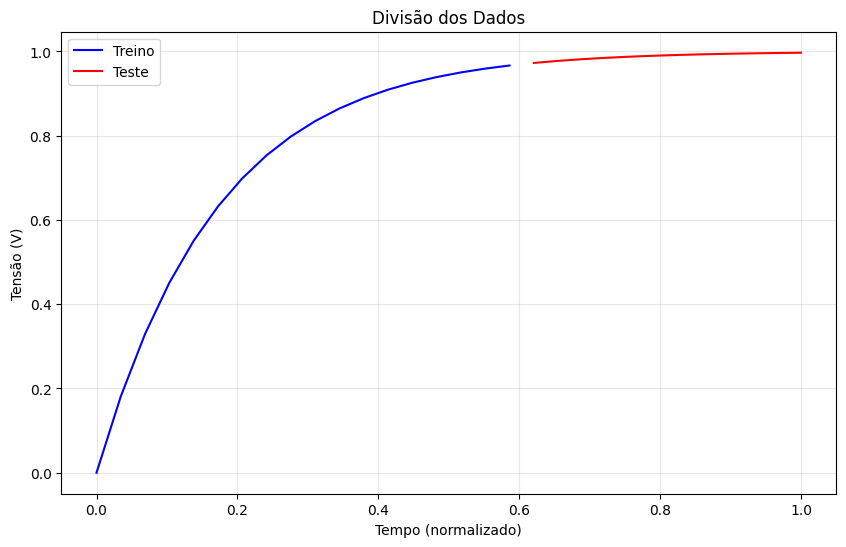


4. Criando e treinando a rede neural...
Visualizando pesos antes do treinamento...


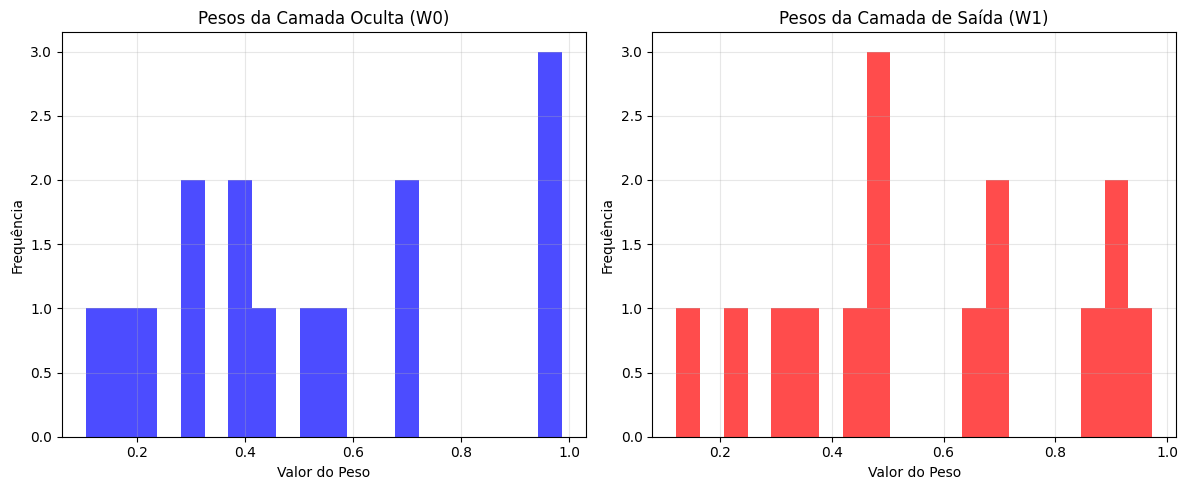

Iniciando treinamento por 500 épocas...
Época 100/500 - Erro: 0.073964
Época 200/500 - Erro: 0.069552
Época 300/500 - Erro: 0.062967
Época 400/500 - Erro: 0.052919
Época 500/500 - Erro: 0.039872
Treinamento concluído! Erro final: 0.039872
Visualizando pesos após o treinamento...


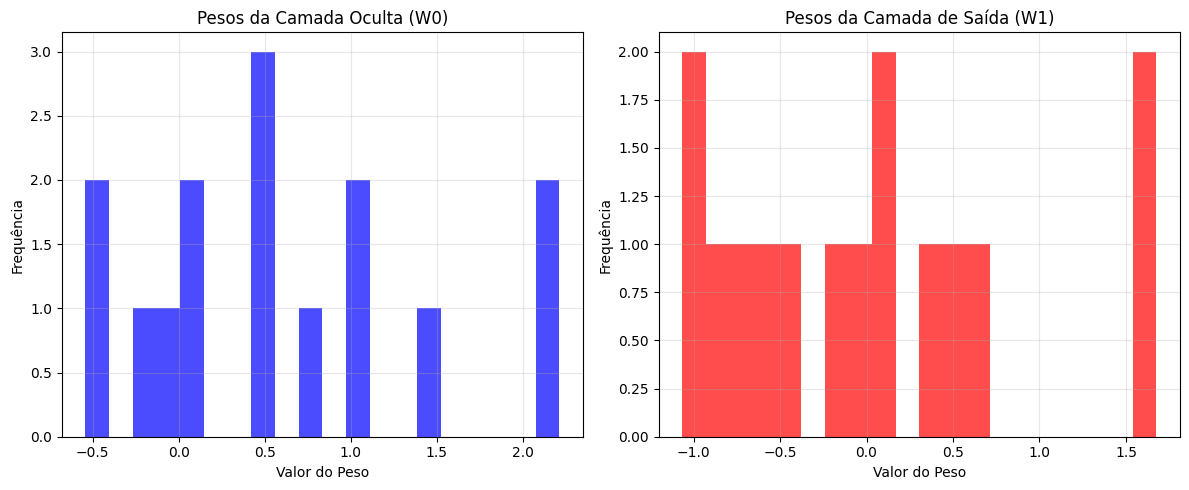


5. Visualizando convergência...


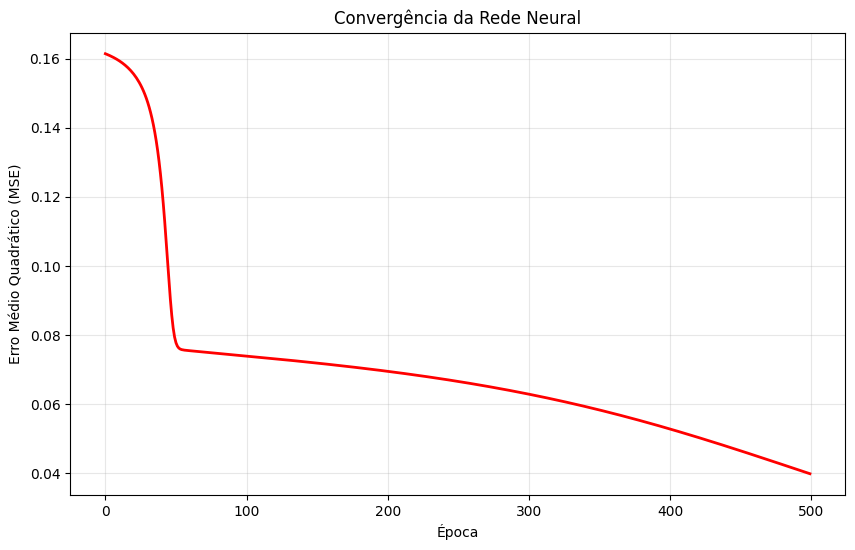


6. Testando a rede...
Erro de teste (MSE): 0.015698

7. Visualização final...


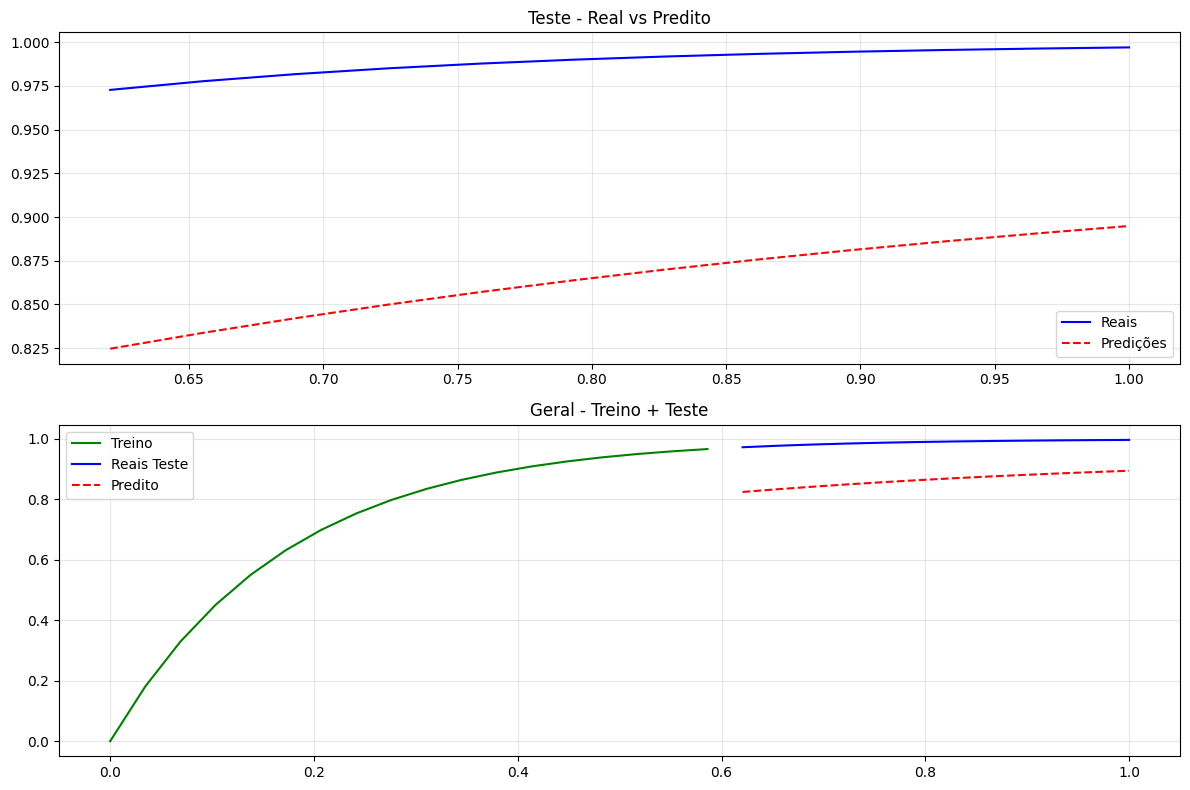


8. Resumo:
- Erro final de treinamento: 0.039872
- Erro de teste: 0.015698
- Parâmetros: 30
- Arquitetura: 1 -> 15 -> 1

=== FIM DA DEMONSTRAÇÃO ===


In [8]:
# ▶️ Executar a demonstração
rede_treinada = demonstracao_completa()
